# Çok Sınıflı Sınıflandırma (Multiclass Classification)

Son not defterinde, ikili sınıflandırmaya (binary classification) baktık. Bu, verideki gözlemler iki sınıftan birine ait olduğunda iyi çalışır; örneğin "Doğru" ya da "Yanlış" gibi. Veri iki sınıftan daha fazlasına ayrıldığında, çok sınıflı sınıflandırma algoritması kullanmanız gerekir.

Çok sınıflı sınıflandırma, birden çok ikili sınıflandırıcının kombinasyonu olabilir. Bu problemi çözmenin iki yolu vardır:

- **Bir'e Karşı Diğerleri (One vs Rest - OVR)**: Her olası sınıf değeri için bir sınıflandırıcı oluşturulur. Bu sınıflandırıcı, tahminin *bu* sınıf olduğu durumlarda pozitif, diğer tüm sınıflar için ise negatif sonuç verir. Örneğin, dört farklı şekil sınıfı (*kare*, *daire*, *üçgen*, *altıgen*) olan bir sınıflandırma problemi için dört sınıflandırıcı gerekir:
    - *kare* mi değil mi
    - *daire* mi değil mi
    - *üçgen* mi değil mi
    - *altıgen* mi değil mi
    
- **Bir'e Karşı Bir (One vs One - OVO)**: Her olası sınıf çifti için bir sınıflandırıcı oluşturulur. Dört şekil sınıfı için gerekli ikili sınıflandırıcılar şunlardır:
    - *kare* mi yoksa *daire* mi
    - *kare* mi yoksa *üçgen* mi
    - *kare* mi yoksa *altıgen* mi
    - *daire* mi yoksa *üçgen* mi
    - *daire* mi yoksa *altıgen* mi
    - *üçgen* mi yoksa *altıgen* mi

Her iki yaklaşımda da, sınıflandırıcıları birleştiren genel model, bireysel ikili sınıflandırıcılardan elde edilen olasılıkları kullanarak hangi sınıfın tahmin edileceğine karar veren bir tahmin vektörü oluşturur.

Neyse ki, Scikit-Learn dahil olmak üzere çoğu makine öğrenimi framework’ü, çok sınıflı sınıflandırma modelini ikili sınıflandırmadan önemli ölçüde daha karmaşık olmadan uygulamaya imkân verir — ve çoğu durumda ikili sınıflandırma için kullanılan kestiriciler (estimators), OVR algoritmasını, OVO algoritmasını soyutlayarak veya bunlardan birini seçme olanağı sunarak çok sınıflı sınıflandırmayı destekler.

> **Daha Fazla Bilgi**: Scikit-Learn’de çok sınıflı sınıflandırma desteği hakkında daha fazla bilgi için [Scikit-Learn dökümantasyonuna](https://scikit-learn.org/stable/modules/multiclass.html) bakabilirsiniz.

---

### Veriyi Keşfet (Explore the data)

Çoklu sınıflara ait gözlemler içeren bir veri kümesini inceleyerek başlayalım. Üç farklı penguen türüne ait gözlemleri içeren bir veri kümesi kullanacağız.

> **Kaynak:** Bu egzersizde kullanılan penguen veri kümesi, [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) ve [Palmer Station, Antarctica LTER](https://lternet.edu/site/palmer-antarctica-lter) tarafından toplanan ve [Uzun Vadeli Ekolojik Araştırma Ağı (Long Term Ecological Research Network)](https://lternet.edu) üyesi olan verilerin bir alt kümesidir.


In [181]:
# pandas kütüphanesini ekle
import pandas as pd

# 'penguins.csv' dosyasını oku ve DataFrame'e yükle
penguins = pd.read_csv('penguins.csv')

# Veriden rastgele 10 örnek seç
sample = penguins.sample(10)

# Seçilen örnekleri göster
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
34,36.4,17.0,195.0,3325.0,0
275,49.9,16.1,213.0,5400.0,1
245,49.5,16.1,224.0,5650.0,1
210,43.2,14.5,208.0,4450.0,1
65,41.6,18.0,192.0,3950.0,0
238,43.4,14.4,218.0,4600.0,1
99,43.2,18.5,192.0,4100.0,0
300,46.7,17.9,195.0,3300.0,2
298,43.2,16.6,187.0,2900.0,2
248,49.4,15.8,216.0,4925.0,1


Veri seti aşağıdaki sütunları içerir:

* **CulmenLength**: Penguenin gagasının (culmen) uzunluğu, milimetre (mm) cinsinden.
* **CulmenDepth**: Penguenin gagasının derinliği, milimetre (mm) cinsinden.
* **FlipperLength**: Penguenin yüzgecinin (flipper) uzunluğu, milimetre (mm) cinsinden.
* **BodyMass**: Penguenin vücut kütlesi, gram cinsinden.
* **Species**: Penguen türünü temsil eden bir tamsayı değeri.

**Species** sütunu, modelimizi eğitmek için tahmin etmeye çalışacağımız etikettir. Veri setinde üç farklı penguen türü vardır ve bu türler 0, 1 ve 2 olarak kodlanmıştır. Gerçek tür isimleri aşağıdaki kod ile ortaya çıkarılacaktır:


In [182]:
# Penguen türleri listesi (etiketler)
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']

# İlk 5 sütunun isimlerini ve 'SpeciesName' ifadesini yazdır
print(sample.columns[0:5].values, 'SpeciesName')

# Veri içinden rastgele 10 satır seç, her satırı tek tek işle
for index, row in penguins.sample(10).iterrows():
    # Satırdaki ilk 5 sütunu ve tür ismini yazdır
    # row[0], row[1], row[2], row[3] → sütun değerleri
    # row[4] → türü gösteren sayı, int'e çevrilip penguin_classes ile eşleştiriliyor
    print('[', row[0], row[1], row[2], row[3], int(row[4]), ']', penguin_classes[int(row[4])])

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 41.3 21.1 195.0 4400.0 0 ] Adelie
[ 55.8 19.8 207.0 4000.0 2 ] Chinstrap
[ 41.1 18.2 192.0 4050.0 0 ] Adelie
[ 45.6 19.4 194.0 3525.0 2 ] Chinstrap
[ 42.2 19.5 197.0 4275.0 0 ] Adelie
[ 40.2 17.0 176.0 3450.0 0 ] Adelie
[ 37.7 18.7 180.0 3600.0 0 ] Adelie
[ 39.6 17.7 186.0 3500.0 0 ] Adelie
[ 40.5 18.9 180.0 3950.0 0 ] Adelie
[ 45.1 14.5 207.0 5050.0 1 ] Gentoo


/var/folders/4f/wvgl49117kq51xm26tw2kxhm0000gn/T/ipykernel_1767/845245061.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('[', row[0], row[1], row[2], row[3], int(row[4]), ']', penguin_classes[int(row[4])])


Artık verideki özelliklerin (features) ve etiketlerin (labels) neyi temsil ettiğini bildiğimize göre, veri setini keşfetmeye başlayalım. 

İlk olarak, eksik (*null*) değerler olup olmadığını kontrol edelim.


In [183]:
penguins.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

Görünüşe göre bazı eksik özellik (feature) değerleri var, ancak eksik etiket (label) yok. 
Biraz daha derine inelim ve *null* (eksik) içeren satırları görelim.


In [184]:
penguins[penguins.isnull().any(axis=1)]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


İki satırda hiç özellik (feature) değeri bulunmuyor (*NaN* "sayı değil" anlamına gelir), bu nedenle bu satırlar modeli eğitmek için faydalı olmayacaktır. Hadi bu satırları veri kümesinden çıkaralım.

In [185]:
# Eksik verileri (NaN) içeren satırları sil
penguins = penguins.dropna()

# Her sütundaki eksik değer sayısını kontrol et
penguins.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

Artık eksik değerleri ele aldığımıza göre, kutu grafikleri (box chart) oluşturarak özelliklerin (features) etiketle (label) nasıl bir ilişki kurduğunu inceleyelim.


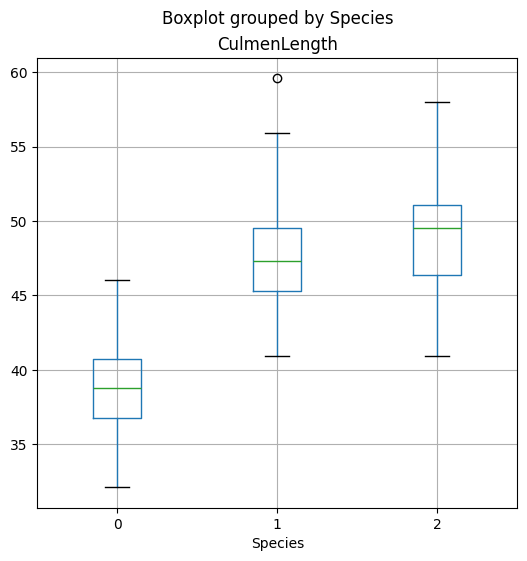

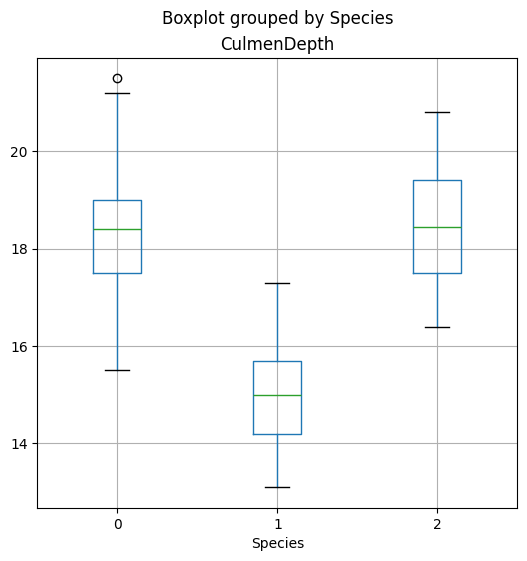

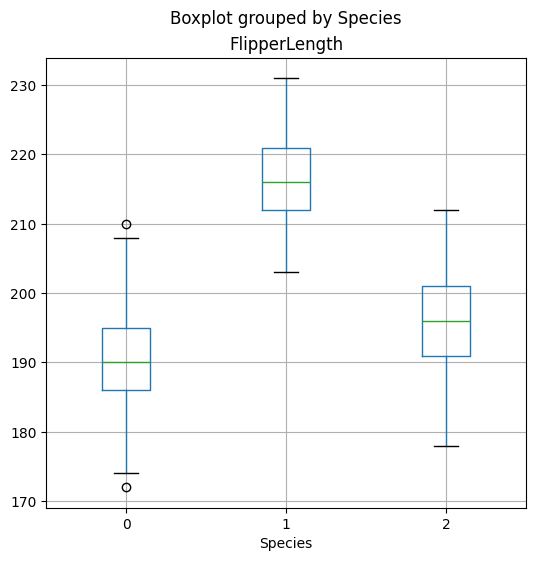

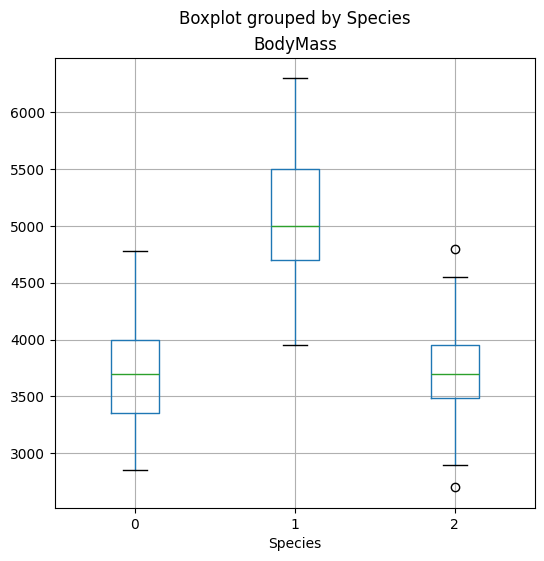

In [186]:
# Grafik çizimi için matplotlib kütüphanesini ekle
import matplotlib.pyplot as plt

# Jupyter içinde grafiklerin görünmesini sağlar
%matplotlib inline

# Analiz için kullanılacak özellikler
penguin_features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']

# Hedef sütun (tür bilgisi)
penguin_label = 'Species'

# Her özellik için kutu grafiği çiz, türlere göre grupla
for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6, 6))
    plt.title(col)

# Tüm grafikleri göster
plt.show()

Kutu grafiklerinden, tür 0 ve 2'nin (Adelie ve Chinstrap) culmen derinliği, yüzgeç uzunluğu ve vücut kütlesi açısından benzer veri profillerine sahip oldukları görülüyor; ancak Chinstrap penguenleri genellikle daha uzun culmenlere sahip. Tür 1 (Gentoo) ise diğerlerinden oldukça belirgin şekilde ayrılan özelliklere sahip gibi görünüyor, bu da iyi bir sınıflandırma modeli eğitmemize yardımcı olacaktır.

### Veriyi Hazırlama

İkili sınıflandırmada olduğu gibi, modeli eğitmeden önce özellikleri ve etiketi ayırmamız, ardından veriyi eğitim ve doğrulama alt kümelerine bölmemiz gerekiyor. Ayrıca, eğitim ve doğrulama veri kümelerindeki her bir etiket değerinin oranını korumak için *stratifikasyon* (katmanlama) tekniğini uygulayacağız.

In [187]:
# Veriyi eğitim ve test olarak ayırmak için sklearn'den fonksiyon alıyoruz
from sklearn.model_selection import train_test_split

# Özellikleri (p_x) ve hedefi (p_y) ayırıyoruz
p_x, p_y = penguins[penguin_features].values, penguins[penguin_label].values

# Veriyi eğitim ve test setlerine bölüyoruz
# test_size=0.3 → %30 test, %70 eğitim
# random_state=0 → her seferinde aynı bölünme için sabit tohum
# stratify=p_y → sınıf dağılımını eğitim ve testte korur
p_x_train, p_x_test, p_y_train, p_y_test = train_test_split(p_x, p_y, test_size=0.3, random_state=0, stratify=p_y)

# Eğitim ve test setindeki örnek sayısını yazdırıyoruz
print(f"Training Set: {p_x_train.shape[0]}\nTest Set: {p_x_test.shape[0]}")

Training Set: 239
Test Set: 103


### Çok Sınıflı Bir Sınıflandırıcıyı Eğitme ve Değerlendirme

Artık elimizde bir eğitim özelliği kümesi ve buna karşılık gelen eğitim etiketleri olduğuna göre, veriye çok sınıflı bir sınıflandırma algoritması uygulayarak bir model oluşturabiliriz. Scikit-Learn kütüphanesindeki çoğu sınıflandırma algoritması, çok sınıflı sınıflandırmayı doğal olarak destekler. Biz de bir lojistik regresyon algoritmasını deneyeceğiz.


In [188]:
# Lojistik regresyon modelini sklearn'den alıyoruz
from sklearn.linear_model import LogisticRegression

# Regülerizasyon parametresi (küçük değer → güçlü regülerizasyon)
reg = 0.1

# Çoklu sınıf lojistik regresyon modeli oluşturuyoruz ve eğitiyoruz
# C=1/reg → regülerizasyonun tersi, büyük C az regülerizasyon demek
# solver='lbfgs' → çoklu sınıf problemi için uygun ve hızlı algoritma
# max_iter=10000 → algoritmanın maksimum iterasyon sayısı (çok uzun süren durumlar için artırıldı)
multi_model = LogisticRegression(C=1/reg, solver='lbfgs', max_iter=10000).fit(p_x_train, p_y_train)

# Eğitilen modeli yazdır
print(multi_model)

LogisticRegression(C=10.0, max_iter=10000)


Artık eğitilmiş modeli kullanarak test özelliklerine ait etiketleri tahmin edebilir ve tahmin edilen etiketleri gerçek etiketlerle karşılaştırabiliriz.

In [189]:
# Test verisi için penguen türlerini tahmin et
penguin_pred = multi_model.predict(p_x_test)

# İlk 15 tahmini yazdır
print("Predicted labels:", penguin_pred[:15])

# İlk 15 gerçek etiketi yazdır
print("Actual labels   :", p_y_test[:15])

Predicted labels: [0 1 0 2 2 1 1 1 0 2 2 1 2 1 2]
Actual labels   : [0 1 2 2 2 1 1 1 0 2 2 1 2 1 2]


Haydi bir sınıflandırma raporuna bakalım.


In [190]:
# Sınıflandırma performansını detaylı gösteren raporu içe aktar
from sklearn.metrics import classification_report

# Gerçek ve tahmin edilen etiketler ile raporu yazdır
# Raporda precision, recall, f1-score ve destek gibi metrikler bulunur
print(classification_report(p_y_test, penguin_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



İkili sınıflandırmada olduğu gibi, rapor her sınıf için *kesinlik (precision)* ve *duyarlılık (recall)* metriklerini içerir. Ancak, ikili sınıflandırmada *pozitif* sınıfa ait değerlere odaklanabilirken; bu durumda birden fazla sınıf olduğundan, modelin tüm üç sınıfta ne kadar iyi performans gösterdiğini anlamak için genel bir metriğe (ya *makro* ya da *ağırlıklı ortalama*) bakmamız gerekir.

Genel metrikleri sınıflandırma raporundan ayrı olarak Scikit-Learn'ün `metrics` sınıflarını kullanarak da alabilirsiniz; ancak çok sınıflı (multiclass) sonuçlar için, kesinlik ve duyarlılık hesaplanırken hangi ortalamanın kullanılacağını belirtmeniz gerekir.


In [191]:
# Değerlendirme metriklerini sklearn'den alıyoruz
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Genel doğruluk oranını hesapla ve yazdır
print("Overall Accuracy:", accuracy_score(p_y_test, penguin_pred))

# Çoklu sınıf için ortalama recall değerini hesapla ve yazdır
print("Overall Recall   :", recall_score(p_y_test, penguin_pred, average='macro'))

# Çoklu sınıf için ortalama precision değerini hesapla ve yazdır
print("Overall Precision:", precision_score(p_y_test, penguin_pred, average='macro'))

Overall Accuracy: 0.970873786407767
Overall Recall   : 0.9608465608465608
Overall Precision: 0.9688405797101449


Şimdi modelimiz için karışıklık matrisine bakalım.


In [192]:
# Karışıklık matrisi fonksiyonunu sklearn'den alıyoruz
from sklearn.metrics import confusion_matrix

# Gerçek ve tahmin edilen sınıflardan karışıklık matrisini oluştur
mcm = confusion_matrix(p_y_test, penguin_pred)

# Matrisi yazdır
print(mcm)

[[44  0  1]
 [ 0 37  0]
 [ 2  0 19]]


Karışıklık matrisi, her sınıf için tahmin edilen ve gerçek etiket değerlerinin kesişimini gösterir. Sol üstten sağ alta doğru olan diyagonal kesişimler, doğru tahmin edilen örneklerin sayısını belirtir.

Birden fazla sınıfla çalışırken, bu matrisi bir ısı haritası olarak görselleştirmek genellikle daha anlaşılır olur.


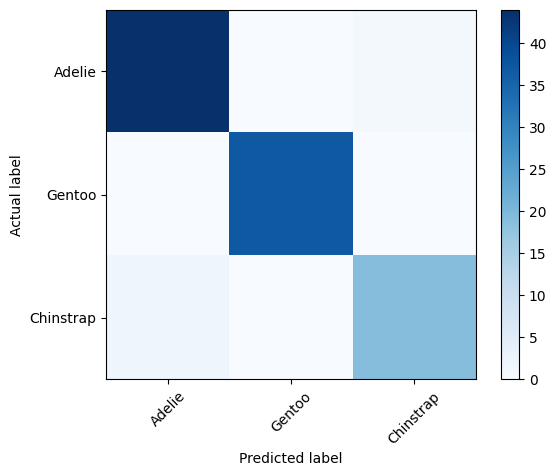

In [193]:
# Numpy ve matplotlib kütüphanelerini ekle
import numpy as np
import matplotlib.pyplot as plt

# Jupyter içinde grafiklerin görünmesini sağlar
%matplotlib inline

# Karışıklık matrisini renkli bir görüntü olarak göster
plt.imshow(mcm, interpolation='nearest', cmap=plt.cm.Blues)

# Renk skalası çubuğunu ekle
plt.colorbar()

# Sınıf sayısı kadar işaret oluştur (0'dan başlayarak)
tick_marks = np.arange(len(penguin_classes))

# x ve y eksenlerine sınıf isimlerini yaz, x ekseninde yazıları 45 derece döndür
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)

# Eksen isimleri
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# Grafiği göster
plt.show()

Karışıklık matrisi grafiğindeki daha koyu kareler, daha yüksek sayıda örneği temsil eder. Umuyoruz ki, tahmin edilen etiket ile gerçek etiketin aynı olduğu durumları gösteren diyagonal bir koyu çizgi görebilirsiniz.

Çok sınıflı (multiclass) bir sınıflandırma modeli durumunda, tek bir ROC eğrisi (doğru pozitif oranı ile yanlış pozitif oranı grafiği) oluşturmak mümkün değildir. Ancak, her sınıf için Diğerlerine Karşı (One vs Rest - OVR) yaklaşımı kullanılarak, her bir sınıf için ayrı bir ROC grafiği oluşturulabilir.


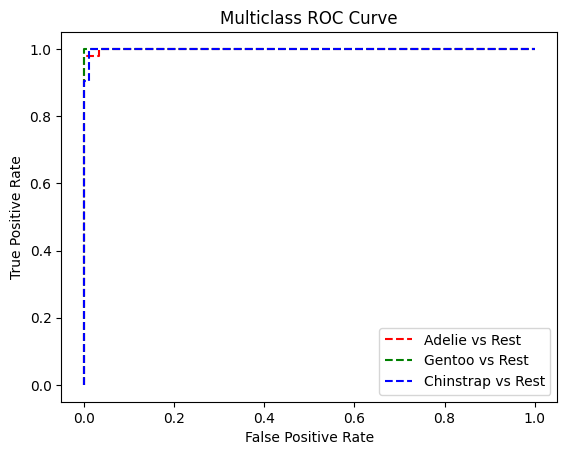

In [194]:
# ROC eğrisi ve AUC hesaplama için sklearn fonksiyonlarını alıyoruz
from sklearn.metrics import roc_auc_score, roc_curve

# Modelin test verisi için sınıf olasılıklarını al
penguin_prob = multi_model.predict_proba(p_x_test)

# Her sınıf için ROC eğrisi değerlerini saklamak üzere boş sözlükler oluştur
fpr = {}   # False Positive Rate
tpr = {}   # True Positive Rate
thresh = {} # Eşik değerleri

# Her sınıf için ROC eğrisi hesapla (one-vs-rest yaklaşımı)
for i in range(len(penguin_classes)):
    fpr[i], tpr[i], thresh[i] = roc_curve(p_y_test, penguin_prob[:, i], pos_label=i)

# Her sınıfın ROC eğrisini farklı renk ve çizgi ile çiz
plt.plot(fpr[0], tpr[0], linestyle='--', color='red', label=penguin_classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label=penguin_classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label=penguin_classes[2] + ' vs Rest')

# Grafik başlığı ve eksen isimleri
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Grafik legendini uygun yere koy
plt.legend(loc='best')

# Grafiği göster
plt.show()

ROC performansını nicel olarak ifade etmek için, tüm OVR (Diğerlerine Karşı) eğrileri üzerinden ortalaması alınan toplam eğri altı alan (AUC - Area Under the Curve) skoru hesaplanabilir.


In [195]:
# Çoklu sınıf için ROC AUC skorunu hesapla
auc = roc_auc_score(p_y_test, penguin_prob, multi_class='ovr')

# AUC skorunu yazdır
print("AUC Score:", auc)

AUC Score: 0.9993574254297553


### Verileri bir işlem hattında (pipeline) ön işleme tabi tutma

Yine, ikili sınıflandırmada olduğu gibi, bir işlem hattı (pipeline) kullanarak verileri modele eğitmeden önce bazı ön işleme adımlarına tabi tutabilirsiniz. Eğitimden önce sayısal özellikleri ölçeklendiren bir dönüşüm adımı ekleyerek penguen tahmincisini geliştirip geliştiremeyeceğimize bakalım. Ayrıca, sadece bunu yapabileceğimizi göstermek amacıyla farklı bir algoritma olan *destek vektör makineleri (support vector machine)* yöntemini de deneyeceğiz.


In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Kullanacağımız özellik sütunlarının indeksleri
feature_columns = [0, 1, 2, 3]

# Sayısal özellikleri standartlaştırmak için pipeline oluşturuyoruz
# StandardScaler, her sütunu ortalaması 0, standart sapması 1 olacak şekilde dönüştürür
# Bu, özellikle SVM gibi ölçek duyarlı modeller için önemlidir
feature_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ColumnTransformer ile belirlenen sütunlara yukarıdaki dönüştürmeyi uygularız
# Böylece yalnızca sayısal özellikler ölçeklendirilir, diğer sütunlar etkilenmez
preprocessor = ColumnTransformer(
    transformers=[
        ('preprocess', feature_transformer, feature_columns)
    ]
)

# Pipeline oluşturuyoruz
# Önce veriyi ön işlemden geçiriyoruz (standartlaştırma)
# Sonra SVM (Support Vector Classifier) ile sınıflandırma yapıyoruz
# SVC, veriyi farklı sınıflara ayırmak için en uygun sınır çizgisini bulmaya çalışır
# probability=True ile model, tahminlerin yanı sıra sınıfa ait olma olasılıklarını da hesaplar
# Bu olasılıklar, ROC ve AUC gibi performans metriklerinde kullanılır
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVC(probability=True))
])

# Pipeline'ı eğitim verisiyle eğitiyoruz
multi_model = pipeline.fit(p_x_train, p_y_train)

# Eğitilmiş modelin temel bilgisini yazdırıyoruz
print(multi_model)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', SVC(probability=True))])


Şimdi yeni modeli değerlendirelim.


Overall Accuracy: 0.9805825242718447
Overall Precision: 0.9767195767195768
Overall Recall: 0.9767195767195768
Average AUC: 0.9990361381446328


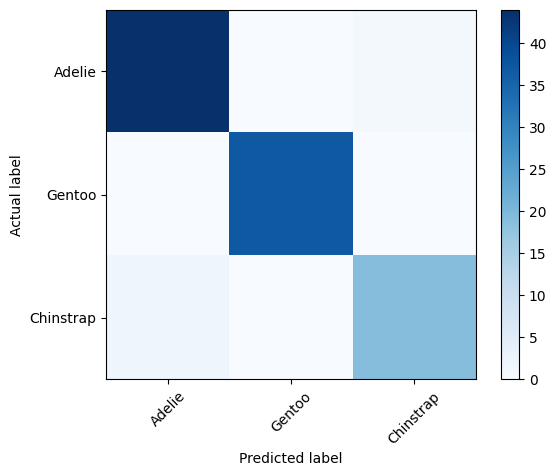

In [197]:
# Test verisi için tür tahminleri yapıyoruz
penguin_pred = multi_model.predict(p_x_test)

# Test verisi için her sınıfa ait olma olasılıklarını tahmin ediyoruz
penguin_prob = multi_model.predict_proba(p_x_test)

# Genel doğruluk oranını hesapla ve yazdır
print("Overall Accuracy:", accuracy_score(p_y_test, penguin_pred))

# Çoklu sınıf için ortalama kesinlik (precision) skorunu hesapla ve yazdır
print("Overall Precision:", precision_score(p_y_test, penguin_pred, average='macro'))

# Çoklu sınıf için ortalama duyarlılık (recall) skorunu hesapla ve yazdır
print("Overall Recall:", recall_score(p_y_test, penguin_pred, average='macro'))

# Çoklu sınıf için ortalama AUC skorunu hesapla ve yazdır (One-vs-Rest yöntemi)
print("Average AUC:", roc_auc_score(p_y_test, penguin_prob, multi_class='ovr'))

# Karışıklık matrisini ısı haritası olarak görselleştiriyoruz
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)

# Renk skalası ekliyoruz
plt.colorbar()

# Sınıf sayısı kadar işaret oluşturuyoruz
tick_marks = np.arange(len(penguin_classes))

# X ve Y eksenine sınıf isimlerini yazıyoruz, X eksenindeki yazıları 45 derece döndürüyoruz
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)

# Eksen isimleri
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# Grafiği gösteriyoruz
plt.show()

### Yeni veri gözlemleri ile modeli kullanma

En yeni eğitilmiş modelimizi kaydederek, daha sonra tekrar kullanabilmemizi sağlayalım.


In [198]:
# joblib kütüphanesini kullanarak modeli diske kaydetmek için içe aktar
import joblib

# Eğitilmiş modeli 'penguin_multi_model.pkl' adlı dosyaya kaydet
filename = 'penguin_multi_model.pkl'
joblib.dump(multi_model, filename)

['penguin_multi_model.pkl']

Şimdi modeli kullanarak yeni bir penguen gözleminin sınıfını tahmin edelim.


In [199]:
# Daha önce kaydettiğimiz modeli dosyadan yükle
multi_model = joblib.load(filename)

# Yeni bir penguen örneği (özellikler: CulmenLength, CulmenDepth, FlipperLength, BodyMass)
x_new = np.array([[50.4, 15.3, 224, 5550]])
print(f"New sample: {x_new[0]}")

# Yeni örnek için tahmin yap (tek örnek olduğu için [0] ile sonucu alıyoruz)
penguin_pred = multi_model.predict(x_new)[0]

# Tahmin edilen sınıf indeksini penguin_classes listesinden isim olarak yazdır
print(f"Predicted class is {penguin_classes[penguin_pred]}")

New sample: [  50.4   15.3  224.  5550. ]
Predicted class is Gentoo


Ayrıca modele birden fazla penguen gözlemi gönderip, her biri için tahmin alabilirsiniz.


In [200]:
# Yeni iki penguen örneği, her satır bir örnek, sütunlar özellikler (CulmenLength, CulmenDepth, FlipperLength, BodyMass)
x_new = np.array([[49.5, 18.4, 195, 3600],
                  [38.2, 20.1, 190, 3900]])
print(f"New samples:\n{x_new}")

# Model ile bu yeni örnekler için tür tahminleri yap
predictions = multi_model.predict(x_new)

# Tahmin sonuçlarını yazdır (sınıf indeksini ve sınıf ismini)
for prediction in predictions:
    print(prediction, '(' + penguin_classes[prediction] + ')')

New samples:
[[  49.5   18.4  195.  3600. ]
 [  38.2   20.1  190.  3900. ]]
2 (Chinstrap)
0 (Adelie)
